<a href="https://colab.research.google.com/github/mouleenajaiswal1/CapstoneProject2/blob/main/Copy_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
#Import Dataset
nyc_data= pd.read_csv("/content/drive/MyDrive/Capstone project 2/NYC Taxi Data.csv")

In [80]:
#Top 5 rows
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [81]:
#Check number of rows and columns
print("Number of rows is: ", nyc_data.shape[0])
print("Number of columns is: ", nyc_data.shape[1])

Number of rows is:  1458644
Number of columns is:  11


In [82]:
#statistics
nyc_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [83]:
# features in our dataset
nyc_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [84]:
# Check  number of unique id 
print( 'We have %d unique id in our dataset ' %(nyc_data.id.nunique()))

We have 1458644 unique id in our dataset 


In [85]:
#Check any NAN/NULL records
nyc_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no NAN/NULL values in our dataset (i.e we have no missing values in our dataset).Hence, we don't need to replace/remove null values.




In [86]:
 #Info of all features
 nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


From above, 
* Most of the features are numerical(7 features)
* we have 'pickup_datetime', 'dropoff_datetime' of the type 'object' as date and datetime are an object in Python.We can convert it into type 'datetime' using Datetime module.

In [87]:
import datetime as dt
nyc_data['pickup_datetime'] = pd.to_datetime(nyc_data['pickup_datetime'])
nyc_data['dropoff_datetime'] = pd.to_datetime(nyc_data['dropoff_datetime'])

In [88]:
#Extract and create new features
nyc_data['pickup_weekday']=nyc_data['pickup_datetime'].dt.day_name()

In [89]:
nyc_data['dropoff_weekday']=nyc_data['dropoff_datetime'].dt.day_name()

In [90]:
nyc_data['pickup_weekday_num']=nyc_data['pickup_datetime'].dt.weekday

In [91]:
nyc_data['dropoff_weekday_num']=nyc_data['dropoff_datetime'].dt.weekday

In [92]:
nyc_data['pickup_hour']=nyc_data['pickup_datetime'].dt.hour

In [93]:
nyc_data['dropoff_hour']=nyc_data['dropoff_datetime'].dt.hour

In [94]:
nyc_data['month']=nyc_data['pickup_datetime'].dt.month

In [95]:
#Import library  to calculate distance from geographical coordinates.
from geopy.distance import great_circle

In [96]:
#Function to calculate
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [97]:
#Create the feature ‘distance’.
nyc_data['distance'] = nyc_data.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

In [98]:
#Top 5 Rows
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,dropoff_weekday_num,pickup_hour,dropoff_hour,month,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,0,17,17,3,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,6,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,1,6.385108
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,2,19,19,4,1.485501
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,5,13,13,3,1.188590


In [99]:
# Check the data type of all features.
nyc_data.dtypes

id                             object
vendor_id                       int64
pickup_datetime        datetime64[ns]
dropoff_datetime       datetime64[ns]
passenger_count                 int64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
store_and_fwd_flag             object
trip_duration                   int64
pickup_weekday                 object
dropoff_weekday                object
pickup_weekday_num              int64
dropoff_weekday_num             int64
pickup_hour                     int64
dropoff_hour                    int64
month                           int64
distance                      float64
dtype: object

In [100]:
#Perform One-hot Encoding
dummy = pd.get_dummies(nyc_data.store_and_fwd_flag, prefix='store_and_fwd_flag')
nyc_data = pd.concat([nyc_data,dummy], axis = 1)

In [101]:
#Perform One-hot Encoding
dummy = pd.get_dummies(nyc_data.pickup_weekday, prefix='pickup_weekday')
nyc_data = pd.concat([nyc_data,dummy], axis = 1)

In [102]:
#Creating timezone
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [103]:
 # Applying function and creating new columns.
nyc_data['pickup_timeofday']=nyc_data['pickup_hour'].apply(time_of_day)
nyc_data['dropoff_timeofday']=nyc_data['pickup_hour'].apply(time_of_day)

In [104]:
#Top 5 Rows
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,dropoff_weekday_num,pickup_hour,dropoff_hour,month,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,pickup_timeofday,dropoff_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,0,17,17,3,1.498523,1,0,0,1,0,0,0,0,0,Evening,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,6,1.805510,1,0,0,0,0,1,0,0,0,Late night,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,1,6.385108,1,0,0,0,0,0,0,1,0,Morning,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,2,19,19,4,1.485501,1,0,0,0,0,0,0,0,1,Evening,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,5,13,13,3,1.188590,1,0,0,0,1,0,0,0,0,Afternoon,Afternoon


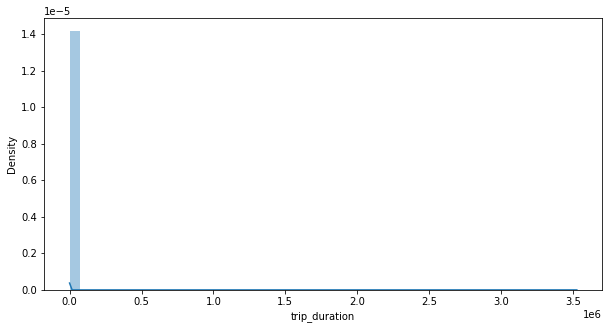

In [105]:
#Plot distribution of target variable
plt.figure(figsize = (10,5))
sns.distplot(nyc_data['trip_duration'])
plt.show()

Since,this histogram is showing right skewness we are applying **the log10** to transform it to the normal distribution.


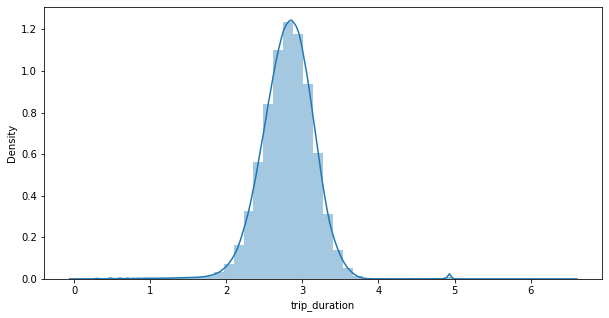

In [106]:
#Plot distribution (after log10 transformation)
plt.figure(figsize = (10,5))
sns.distplot(np.log10(nyc_data['trip_duration']))
plt.show()


To check outliers, we will see the boxplot of this variable.

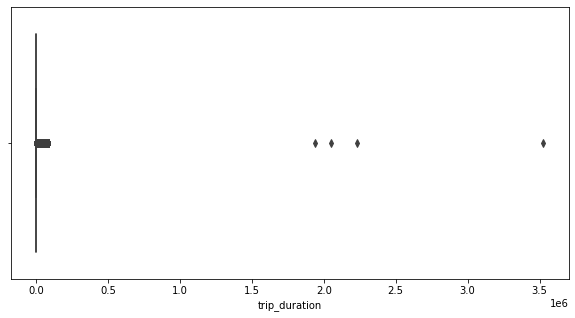

In [107]:
#Plot Boxplot
plt.figure(figsize = (10,5))
sns.boxplot(nyc_data.trip_duration)
plt.show()

###  We can clearly see  outliers and should be removed for the data consistency.


In [108]:

nyc_data['trip_duration'].sort_values(ascending=False)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
            ...   
1034341          1
346102           1
1360664          1
1382872          1
207497           1
Name: trip_duration, Length: 1458644, dtype: int64

*   We can see that major chunk  of trip duration is completed in 3440 seconds i.e. nearly 1 hour. 

*   There are some trips with more than 24 hours of travel duration i.e. 86400 seconds. Which might have occured on weekends for the outstation travels.

*   There are some durations with as low as 1 second. which points towards trips with 0 km distance.



We should get rid the outliers for the sake of data consistency. 

In [109]:
nyc_data = nyc_data[nyc_data.trip_duration <= 86400]

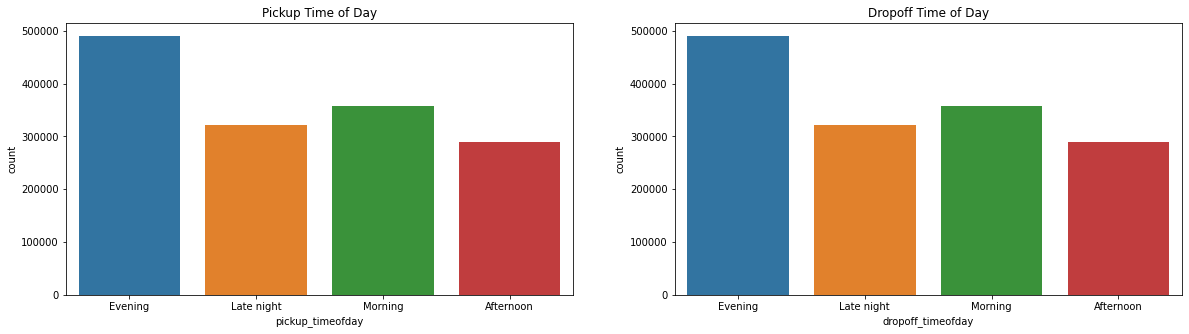

In [110]:
#Plot Trip time for Day
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Time of Day')
ax_1=sns.countplot(x="pickup_timeofday",data=nyc_data,ax=ax1)

ax2.set_title('Dropoff Time of Day')
ax_2=sns.countplot(x="dropoff_timeofday",data=nyc_data,ax=ax2)


### From above, we can conclude :

*   Pickup Time of Day and Dropoff Time of Day are very similar
*   Evenings are the busiest.


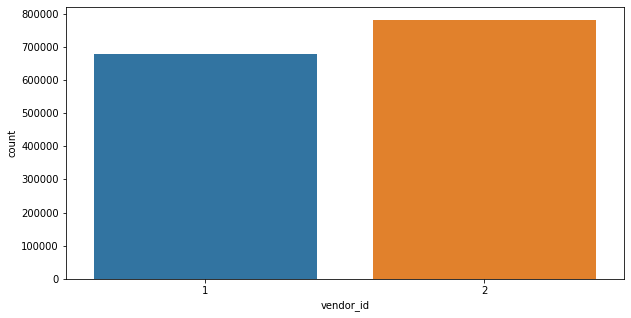

In [111]:
#Plot  for vendor id count
plt.figure(figsize = (10,5))
sns.countplot(nyc_data.vendor_id)
plt.show()

Here,we see that there is not much difference between the trips taken by both vendors.

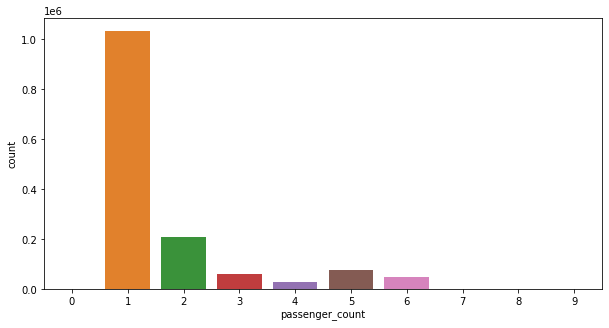

In [112]:
#Plot  for Passenger Count
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=nyc_data)
plt.show()

In [113]:
# remove the rows which have 0 or more than 6 passenger count(as they are empty).
nyc_data=nyc_data[nyc_data['passenger_count']!=0]
nyc_data=nyc_data[nyc_data['passenger_count']<=6]

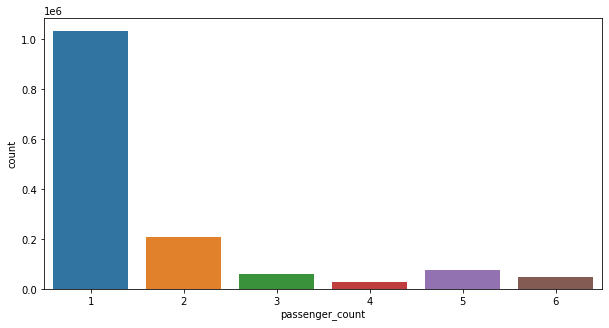

In [114]:
#Plot Countplot for passenger count(after removing unwanted rows)
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=nyc_data)
plt.show()

*   We see the highest amount of trips was taken by a single passenger.
*   The instance of large group of people travelling together is rare.




In [115]:
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,dropoff_weekday_num,pickup_hour,dropoff_hour,month,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,pickup_timeofday,dropoff_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,0,17,17,3,1.498523,1,0,0,1,0,0,0,0,0,Evening,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,6,1.805510,1,0,0,0,0,1,0,0,0,Late night,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,1,6.385108,1,0,0,0,0,0,0,1,0,Morning,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,2,19,19,4,1.485501,1,0,0,0,0,0,0,0,1,Evening,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,5,13,13,3,1.188590,1,0,0,0,1,0,0,0,0,Afternoon,Afternoon


In [116]:
data['store_and_fwd_flag'].value_counts(normalize=True)

N    0.994486
Y    0.005514
Name: store_and_fwd_flag, dtype: float64

###  We can see that only about 1% of the trip details were stored in the vehicle memory first before sending it to the server. 
-  This might have occured because of the GPS or mobile device battery was down when the trip finished.




## **Distance**

In [117]:
nyc_data['distance'].value_counts()

0.000000     5887
0.000424       47
0.000424       44
0.000424       36
0.000424       18
             ... 
21.041878       1
1.495052        1
3.397905        1
7.866919        1
1.336934        1
Name: distance, Length: 1452294, dtype: int64

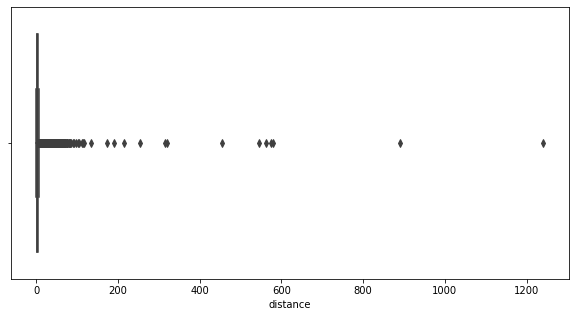

In [118]:
#Plot the boxplot for distance
plt.figure(figsize = (10,5))
sns.boxplot(nyc_data.distance)
plt.show()

*   There are some trips with over 100 km distance.
*   Some of the trips with 0 km distance.

The reasons for 0 km distance can be:
*   The dropoff location couldn’t be tracked.
*   The driver deliberately took this ride to complete a target ride number.
*   The passengers or driver canceled the trip due to some issue.
*   Due to some technical issue in software, etc.

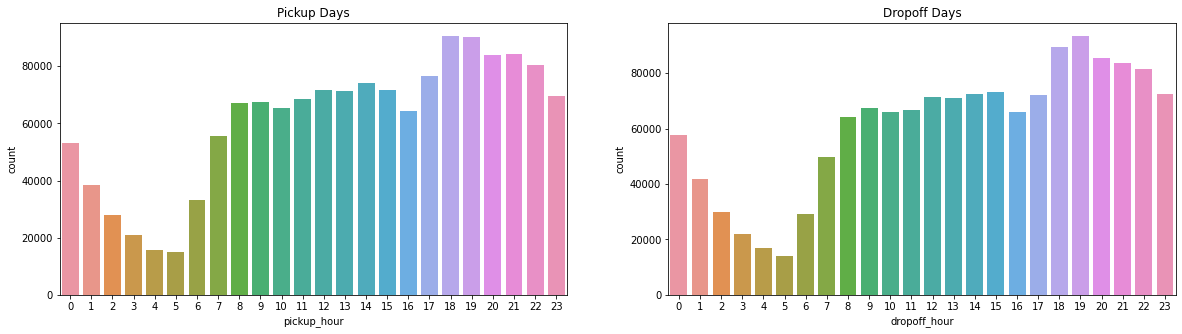

In [119]:
#Plot for Trips per hour count
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Days')
ax_3=sns.countplot(x="pickup_hour",data=nyc_data,ax=ax3)
ax4.set_title('Dropoff Days')
ax_4=sns.countplot(x="dropoff_hour",data=nyc_data,ax=ax4)

*   We see the busiest hours are 6:00 pm to 7:00 pm and that makes sense as this is the time when people return from their offices.



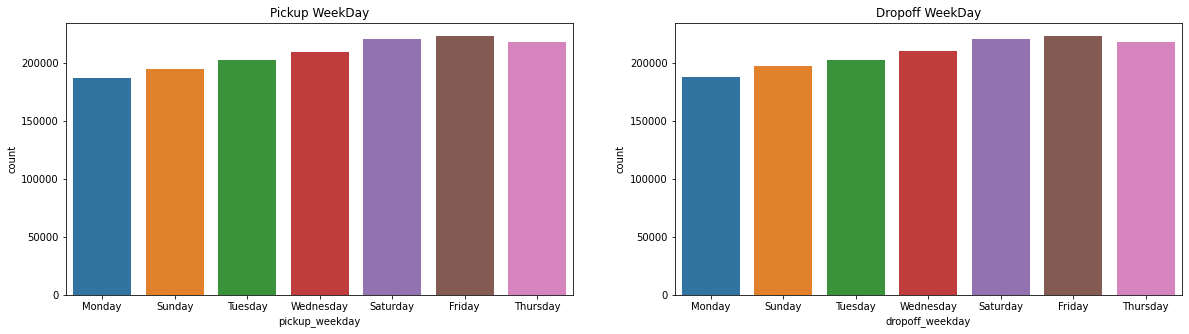

In [120]:
#Plot Trips per week day
figure,(ax5,ax6)=plt.subplots(ncols=2,figsize=(20,5))
ax5.set_title('Pickup WeekDay')
ax_5=sns.countplot(nyc_data.pickup_weekday,data=nyc_data,ax=ax5)
ax6.set_title('Dropoff WeekDay')
ax_6=sns.countplot(nyc_data.dropoff_weekday,data=nyc_data,ax=ax6)

 We can see that Fridays are the busiest days followed by Saturdays. That is probably
because it’s weekend.



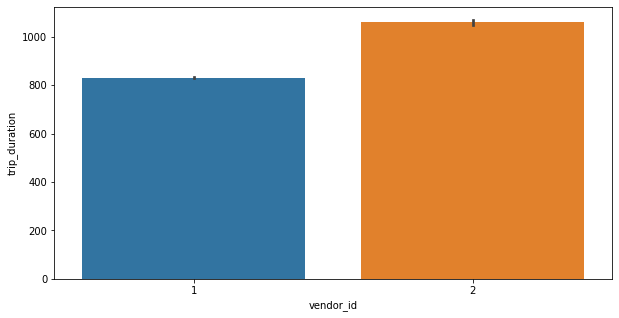

In [121]:
#Plot Trip Duration per Vendor count
plt.figure(figsize = (10,5))
sns.barplot(y='trip_duration',x='vendor_id',data=nyc_data,estimator=np.mean)
plt.show()

### Above data shows that:
*   Vendor id 2 takes longer trips as compared to vendor 1.

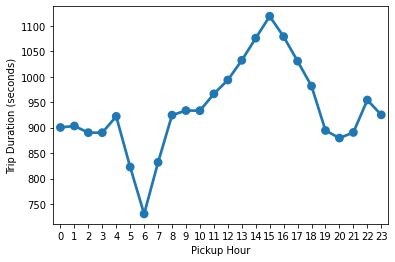

In [122]:
#Plot pointplot for (Trip Duration)/hour
group1 = nyc_data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

The plot shows that:
*   The trip duration is the maximum around 3 pm 
  - may be because of traffic on the roads.
*   Trip duration is the lowest around 6 am 
 - streets may not be busy.

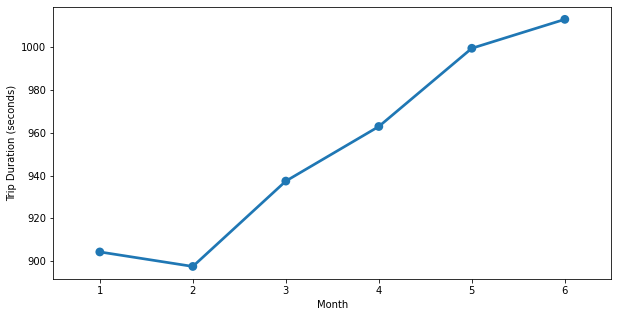

In [123]:
#Plot pointplot for (Trip duration)/Month
plt.figure(figsize = (10,5))
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

Trip duration during months:
*   From February onwords, we can see trip duration have positive linear relationship with other months.
 - There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. 



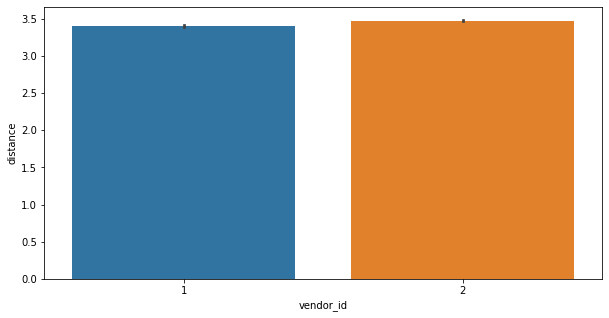

In [124]:
#Plot bar for vendor w.r.t distance
plt.figure(figsize = (10,5))
sns.barplot(y='distance',x='vendor_id',data=nyc_data,estimator=np.mean)
plt.show()

### Distance travelled by both vendors are almost equal.



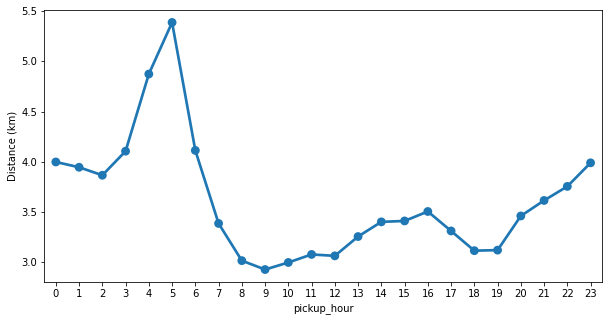

In [125]:
#Plot pointplot for pickup_hour wrt distance

plt.figure(figsize = (10,5))
group5 = nyc_data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

### From above, we can conclude:
*   Trip distance is highest during early morning hours.
*   It is fairly equal from morning till the evening varying around 3 - 3.5 kms.
*   It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.


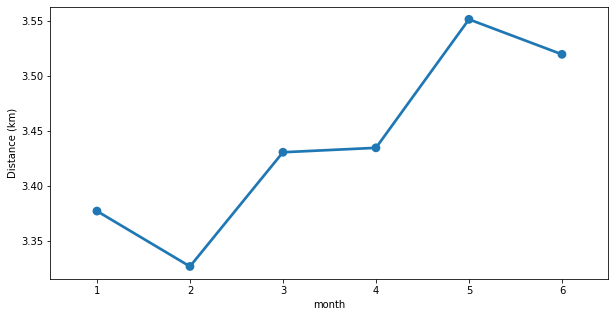

In [126]:
#Plot lineplot for distance and month
plt.figure(figsize = (10,5))
group7 = nyc_data.groupby('month').distance.mean()
sns.pointplot(group7.index, group7.values)
plt.ylabel('Distance (km)')
plt.show()

### Trip Distance during Month:
*   Trip distance and Trip duration are lowest in 2nd month and maximum in 5th month.



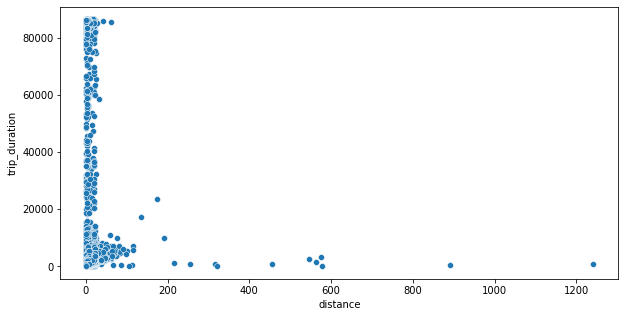

In [127]:
#Plot Scatter plot for Distance and Trip Duration
plt.figure(figsize = (10,5))
sns.scatterplot(x='distance',y='trip_duration',data=nyc_data)
plt.show()

From Trip distance and Trip Duration graph:
*   We can see there are trips which trip duration as short as 0 seconds and yet covering a large distance. And, trips with 0 km distance with long trip durations.
*   Initially there is some proper correlation between the distance covered and the trip duration in the graph. but later on it all seems uncorrelated.
*   There were few trips which covered huge distance of approx 200 kms within very less time frame, which is unlikely and should be treated as outliers.


In [128]:
print('The no of rows with distance = 0 are {}'.format(len(nyc_data[nyc_data.distance==0])))

The no of rows with distance = 0 are 5887


We will not drop  rows with distance=0(as there are many). Rather we will replace these datas with the average distance

In [129]:
mean_dist=nyc_data['distance'].mean()
nyc_data.loc[nyc_data['distance']==0,'distance']=mean_dist

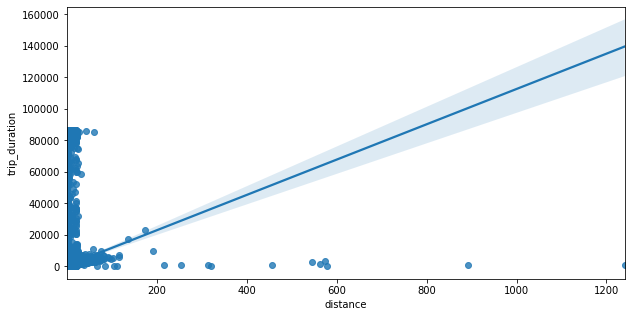

In [130]:
plt.figure(figsize = (10,5))
sns.regplot( nyc_data.distance,nyc_data.trip_duration)
plt.show()

*   Though the straight line tries to show some linear relation between the two. But there seems to be negligible correlation between these two metric as seen from the scatter plot where it should have been a linear distribution.
*   It is rarely occurs that customer keep sitting in the taxi for more than an hour and it does not travel for even 1 km.



In [131]:
#Convert Trip Duration in hour
nyc_data['trip_duration_hour']=nyc_data['trip_duration']/3600

In [132]:
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_weekday_num,dropoff_weekday_num,pickup_hour,dropoff_hour,month,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,pickup_timeofday,dropoff_timeofday,trip_duration_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,0,0,17,17,3,1.498523,1,0,0,1,0,0,0,0,0,Evening,Evening,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,6,1.805510,1,0,0,0,0,1,0,0,0,Late night,Late night,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,1,6.385108,1,0,0,0,0,0,0,1,0,Morning,Morning,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,2,2,19,19,4,1.485501,1,0,0,0,0,0,0,0,1,Evening,Evening,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,5,5,13,13,3,1.188590,1,0,0,0,1,0,0,0,0,Afternoon,Afternoon,0.120833


In [133]:
#Drop features
nyc_data=nyc_data.drop(['id','pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_weekday', 'dropoff_weekday', 'pickup_weekday_num',  'dropoff_weekday_num','pickup_timeofday', 'dropoff_timeofday','trip_duration'], axis=1)
nyc_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,dropoff_hour,month,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,trip_duration_hour
0,2,1,-73.982155,40.767937,-73.964630,40.765602,17,17,3,1.498523,1,0,0,1,0,0,0,0,0,0.126389
1,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0,6,1.805510,1,0,0,0,0,1,0,0,0,0.184167
2,2,1,-73.979027,40.763939,-74.005333,40.710087,11,12,1,6.385108,1,0,0,0,0,0,0,1,0,0.590000
3,2,1,-74.010040,40.719971,-74.012268,40.706718,19,19,4,1.485501,1,0,0,0,0,0,0,0,1,0.119167
4,2,1,-73.973053,40.793209,-73.972923,40.782520,13,13,3,1.188590,1,0,0,0,1,0,0,0,0,0.120833


In [134]:
nyc_data.shape[1]

20

In [135]:
nyc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458575 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   vendor_id                 1458575 non-null  int64  
 1   passenger_count           1458575 non-null  int64  
 2   pickup_longitude          1458575 non-null  float64
 3   pickup_latitude           1458575 non-null  float64
 4   dropoff_longitude         1458575 non-null  float64
 5   dropoff_latitude          1458575 non-null  float64
 6   pickup_hour               1458575 non-null  int64  
 7   dropoff_hour              1458575 non-null  int64  
 8   month                     1458575 non-null  int64  
 9   distance                  1458575 non-null  float64
 10  store_and_fwd_flag_N      1458575 non-null  uint8  
 11  store_and_fwd_flag_Y      1458575 non-null  uint8  
 12  pickup_weekday_Friday     1458575 non-null  uint8  
 13  pickup_weekday_Monday     1

In [136]:
nyc_data.shape

(1458575, 20)

In [137]:
nyc_data.isnull().sum()

vendor_id                   0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
pickup_hour                 0
dropoff_hour                0
month                       0
distance                    0
store_and_fwd_flag_N        0
store_and_fwd_flag_Y        0
pickup_weekday_Friday       0
pickup_weekday_Monday       0
pickup_weekday_Saturday     0
pickup_weekday_Sunday       0
pickup_weekday_Thursday     0
pickup_weekday_Tuesday      0
pickup_weekday_Wednesday    0
trip_duration_hour          0
dtype: int64

*   We don't have any missing values in our dataset.

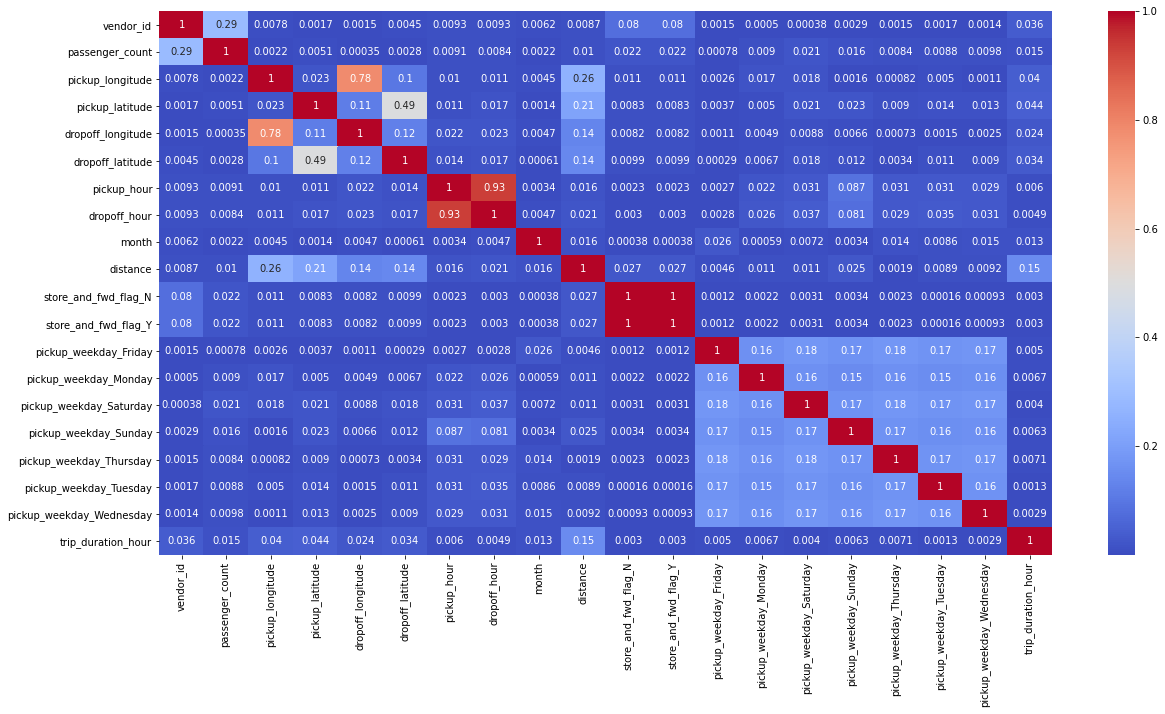

In [138]:
plt.figure (figsize= (20,10))
corelation= nyc_data.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

*   We can see store_and_fwd_flag_y and store_and_fwd_flag_N are highly correlated.  
*   Also they do not affect the target varible i.e. trip_duration_hour much. Hece we should remove these features from our dataset.

In [141]:
nyc_data=nyc_data.drop(['store_and_fwd_flag_N', 'store_and_fwd_flag_Y'], axis=1)

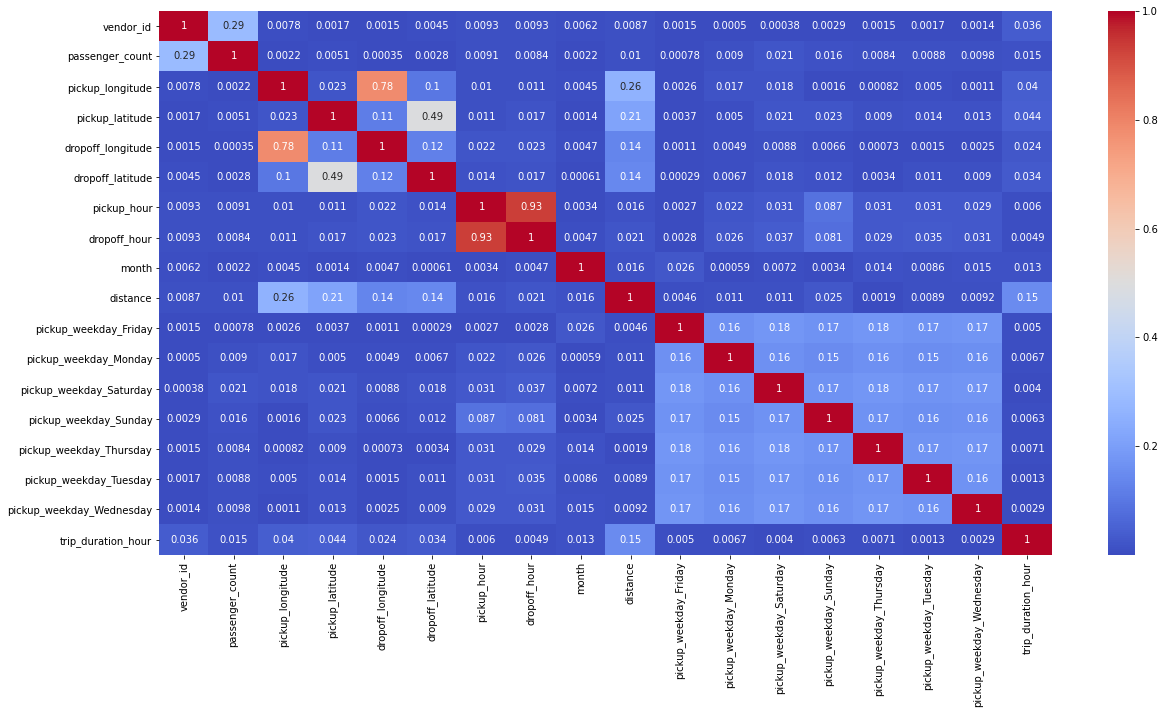

In [142]:
plt.figure (figsize= (20,10))
corelation= nyc_data.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

In [143]:
from sklearn import  metrics
from sklearn.model_selection import cross_val_score
def modelfit(estimator,data_train,data_test,predictors,target):
    #print(data_train.head())
    #fitting model
    estimator.fit(data_train[predictors],data_train.loc[:,target])
    #train data prediction
    train_pred=estimator.predict(data_train[predictors])
    #cross_validation score
    cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=20,scoring='neg_mean_squared_error')
    
    cv_score=np.sqrt(np.abs(cv_score))
    #Print model report:
    print ("\nModel Report")
    print ("RMSE on Train Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_train.loc[:,target].values, train_pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    test_pred=estimator.predict(data_test[predictors])
    print ("RMSE on Test Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_test.loc[:,target].values, test_pred)))
    
    
    
    return test_pred

In [151]:
X, y = nyc_data.drop('trip_duration_hour', axis = 1), nyc_data['trip_duration_hour']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [153]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#Running RFE with output number of the variable  equals to 16
lm =  LinearRegression()
rfe = RFE(lm, n_features_to_select=16)
rfe= rfe.fit(X_train, y_train)
#printing the boolean result
rfe.support_

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [154]:
#Assign the rfe features from X_train into col 
col= X_train.columns[rfe.support_]

In [155]:
#X_train_rfe is nothing but assigning remaining features after eliminating unimportant features from X_train
X_train_rfe= X_train[col]

In [156]:
import statsmodels.api as sm
#Adding a constant variable
X_train_rfe= sm.add_constant(X_train_rfe)

In [157]:
lm= sm.OLS(y_train, X_train_rfe).fit()

In [158]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     trip_duration_hour   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1980.
Date:                Wed, 01 Sep 2021   Prob (F-statistic):               0.00
Time:                        04:07:37   Log-Likelihood:            -1.4877e+06
No. Observations:             1166860   AIC:                         2.975e+06
Df Residuals:                 1166844   BIC:                         2.976e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [159]:
X_test.shape

(291715, 17)

In [160]:
#Making prediction
y_pred_train= lm.predict(X_train_rfe)

In [161]:
X_test_rfe= X_test[col]
#Adding a condtant variable
X_test_rfe= sm.add_constant(X_test_rfe)

#Making prediction
y_pred_test= lm.predict(X_test_rfe)

In [162]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [165]:
lr_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_rmse = np.sqrt(lr_train_mse)

print("Train RMSE :" ,lr_train_rmse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2) 

lr_train_r2_ = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_)


Train MSE : 0.7497985075385907
Train RMSE : 0.8659090642432326
Train R2 : 0.02481726627675873
Train Adjusted R2 :  0.02480305860642007


In [166]:
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_rmse = np.sqrt(lr_test_mse)

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Test MSE : 0.7826285859574866
Test RMSE : 0.8846629787424625
Test R2 : 0.0251838352692213
Test Adjusted R2 :  0.02512702332120531


In [167]:
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_rmse = np.sqrt(lr_test_mse)

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_ = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_)

Test MSE : 0.7826285859574866
Test RMSE : 0.8846629787424625
Test R2 : 0.0251838352692213
Test Adjusted R2 :  0.02512702332120531


In [168]:
from sklearn.tree import DecisionTreeRegressor

In [174]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [8,16,22]

# HYperparameter Grid
param_dict_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}
param_dict_dt

{'max_depth': [4, 6, 8, 10],
 'min_samples_leaf': [8, 16, 22],
 'min_samples_split': [10, 20, 30]}

In [170]:
dt = DecisionTreeRegressor()

In [176]:
dt = DecisionTreeRegressor()

# Randomize search
dt_grid = RandomizedSearchCV(estimator=dt,
                       param_distributions = param_dict_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_samples_split=10, min_samples_leaf=8, max_depth=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=10, min_samples_leaf=8, max_depth=10, total=   7.2s
[CV] min_samples_split=10, min_samples_leaf=8, max_depth=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  min_samples_split=10, min_samples_leaf=8, max_depth=10, total=   7.1s
[CV] min_samples_split=10, min_samples_leaf=8, max_depth=10 ..........
[CV]  min_samples_split=10, min_samples_leaf=8, max_depth=10, total=   8.6s
[CV] min_samples_split=10, min_samples_leaf=8, max_depth=10 ..........
[CV]  min_samples_split=10, min_samples_leaf=8, max_depth=10, total=   9.4s
[CV] min_samples_split=10, min_samples_leaf=8, max_depth=10 ..........
[CV]  min_samples_split=10, min_samples_leaf=8, max_depth=10, total=   8.9s
[CV] min_samples_split=10, min_samples_leaf=16, max_depth=10 .........
[CV]  min_samples_split=10, min_samples_leaf=16, max_depth=10, total=   7.0s
[CV] min_samples_split=10, min_samples_leaf=16, max_depth=10 .........
[CV]  min_samples_split=10, min_samples_leaf=16, max_depth=10, total=   7.0s
[CV] min_samples_split=10, min_samples_leaf=16, max_depth=10 .........
[CV]  min_samples_split=10, min_samples_leaf=16, max_depth=10, total=   7.0s
[CV] min_samples_split=10, min_samples_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                                                   splitter='best'),
                   iid='d

In [178]:
dt_grid.best_score_

0.03177834236371435

In [179]:
dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [180]:
y_pred_dt_train=dt_grid.predict(X_train)

In [181]:
y_pred_dt_test=dt_grid.predict(X_test)

In [182]:
dt_train_mse  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , dt_train_mse)

dt_train_rmse = np.sqrt(dt_train_mse)
print("Train RMSE :" ,dt_train_rmse)

dt_train_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,dt_train_r2)

dt_train_r2_= 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", dt_train_r2_)

Train MSE : 0.7384381967969462
Train RMSE : 0.859324267548023
Train R2 : 0.0395924075628491
Train Adjusted R2 :  0.03957841515507543


In [183]:
dt_test_mse  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_test_mse)
dt_test_rmse = np.sqrt(dt_test_mse)
print("Test RMSE :" ,dt_test_rmse)

dt_test_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,dt_test_r2)

dt_test_r2_= 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", dt_test_r2_)

Test MSE : 0.7771542851315791
Test RMSE : 0.8815635457138522
Test R2 : 0.03200244250060025
Test Adjusted R2 :  0.03194602793864898


In [185]:
n_estimators = [80,150,200]

# Maximum depth of trees
max_depth = [5,7,9]
min_samples_split = [40,50]
learning_rate=[0.2,0.4,0.6]

# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_' : min_samples_split,
             'learning_rate' : learning_rate}

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Randomize search
xgb_grid = RandomizedSearchCV(estimator=xgb_model,
                        param_distributions= param_xgb,
                        cv = 3, verbose=1,
                        scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[04:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_grid.best_score_

In [ ]:
xgb_grid.best_params_

In [ ]:
y_pred_xgb_train=xgb_grid.predict(X_train)

In [ ]:
y_pred_xgb_test=xgb_grid.predict(X_test)

In [ ]:
xgb_train_mse  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , xgb_train_mse)

xgb_train_rmse = np.sqrt(xgb_train_mse)
print("Train RMSE :" ,xgb_train_rmse)

xgb_train_r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,xgb_train_r2)

xgb_train_r2_= 1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", xgb_train_r2_)

In [ ]:
xgb_test_mse  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , xgb_test_mse)

xgb_test_rmse = np.sqrt(xgb_test_mse)
print("Test RMSE :" ,xgb_test_rmse)

xgb_test_r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,xgb_test_r2)

xgb_test_r2_= 1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", xgb_test_r2_)